# DDQN to Beat Mario

## Background

In 2013, DeepMind made the Deep Q Network to play Atari Games (https://arxiv.org/pdf/1312.5602.pdf). This DQN was able to learn to play simple Atari games at human level, kickstarting the past decade of DeepRL research.

In 2015, DeepMind published another paper which played even more Atari Games (https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf). This new model included a target network to reduce Q-value overestimation in the previous DQN model. This model is sometimes called DDQNs, and it's what we'll implement here to beat Mario!

## Setup and Some Exploration

First, we install gymnasium and the Mario Env.

The Mario env can be found here: https://pypi.org/project/gym-super-mario-bros/

In [31]:
# uncomment if using colab; if running locally it's recommended to install via conda
# !pip uninstall -y gym
# !pip install gymnasium
# !pip install gym_super_mario_bros==7.3.0
# !pip install wandb

Before we transform the env with wrappers and make our agent, let's take a look at the environment as-is. Below we take some random actions and generate a video

In [32]:
import gymnasium as gym
from gym.wrappers import RecordVideo

from nes_py.wrappers import JoypadSpace
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT

import numpy as np

import warnings
warnings.filterwarnings('ignore')

env = gym_super_mario_bros.make("SuperMarioBros-1-1-v0", apply_api_compatibility=True, render_mode='rgb_array')
env = JoypadSpace(env, SIMPLE_MOVEMENT)

def run_test(env, num_steps=50):
    frames = []
    out = env.reset()
    for _ in range(num_steps):
        next_state, reward, done, truncated, info = env.step(action=env.action_space.sample())
        frames.append(np.copy(env.render()))
    return frames

frames = run_test(env)

In [33]:
print(frames[-1].shape)

(240, 256, 3)


We can reuse the following code to see what our bot does later on:

In [34]:
# from IPython.display import HTML
# from base64 import b64encode
# import numpy as np
# import os
# import cv2
# from tqdm import tqdm

# def display_vid(frames, vid_name='./video.mp4', compressed_name='./compressed.mp4', fps=30):

#     if os.path.isfile(vid_name):
#       !rm video.mp4
#     if os.path.isfile(compressed_name):
#       !rm compressed.mp4

#     h, w, c = frames[-1].shape
#     out = cv2.VideoWriter(vid_name, cv2.VideoWriter_fourcc(*'VP90'), fps, (w, h))
#     for frame in tqdm(frames):
#         img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#         out.write(img)
#     out.release()

#     os.system(f"ffmpeg -i {vid_name} -vcodec libx264 {compressed_name}")

#     mp4 = open(vid_name,'rb').read()
#     data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
#     return HTML("""
#     <video width=400 controls>
#           <source src="%s" type="video/mp4">
#     </video>
#     """ % data_url)

In [35]:
# display_vid(frames)

## Preprocessing Environment

The DeepMind papers for Atari games transforms the environments to make it easier for the DQN/DDQN to learn. In particular,

1. Use only every 4th frame
2. Grayscale each image, downscale to 110x84, then crop appropriately to remove unnecesssary info
3. Pass a stack of 4 frames so that the model can see trajectory (falling and jumping are different contexts, but may lead to the same observation).


We will implement some of these simplifying transformations using Gymnasium's `gym.Wrapper`. Wrapper code is altered from https://blog.paperspace.com/building-double-deep-q-network-super-mario-bros/.

In [36]:
import collections
import cv2

class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env=None, skip=4):
        super(MaxAndSkipEnv, self).__init__(env)
        self._obs_buffer = collections.deque(maxlen=2)
        self._replay_buffer = collections.deque(maxlen=4)
        self._skip = skip

    def step(self, action):
        total_reward = 0.0
        done = None
        for _ in range(self._skip):
            obs, reward, done, truncated, info = self.env.step(action)
            self._obs_buffer.append(obs)
            self._replay_buffer.append(obs.copy())
            total_reward += reward
            if done:
                break
        max_frame = np.max(np.stack(self._obs_buffer), axis=0)
        return max_frame, total_reward, done, truncated, info

    def render(self, mode='rgb_array'):
        if mode == 'rgb_array':
            return self._replay_buffer
        
        return self.env.render(mode=mode)

    def reset(self, **kwargs):
        self._obs_buffer.clear()
        obs = self.env.reset()
        self._obs_buffer.append(obs)
        return obs


class ProcessFrame84(gym.ObservationWrapper):
    def __init__(self, env=None):
        super(ProcessFrame84, self).__init__(env)
        self.observation_space = gym.spaces.Box(low=0, high=255, shape=(84, 84, 1), dtype=np.uint8)

    def observation(self, observation):
        return ProcessFrame84.process(observation)

    @staticmethod
    def process(frame):
        assert frame.size == 240 * 256 * 3, "Unknown resolution."

        img = np.reshape(frame, [240, 256, 3]).astype(np.float32)
        img = img[:, :, 0] * 0.299 + img[:, :, 1] * 0.587 + img[:, :, 2] * 0.114
        resized_screen = cv2.resize(img, (84, 110), interpolation=cv2.INTER_AREA)
        x_t = resized_screen[18:102, :]
        x_t = np.reshape(x_t, [84, 84, 1])
        return x_t.astype(np.uint8)


class TransposeObs(gym.ObservationWrapper):
    def __init__(self, env):
        super(TransposeObs, self).__init__(env)
        w, h, n = self.observation_space.shape
        self.observation_space = gym.spaces.Box(low=0.0, high=1.0, shape=(n, w, h), dtype=np.float32)

    def observation(self, observation):
        return np.moveaxis(observation, 2, 0)


class ScaledFloatFrame(gym.ObservationWrapper):
    def observation(self, observation):
        return np.array(observation).astype(np.float32) / 255.0


class BufferWrapper(gym.ObservationWrapper):
    def __init__(self, env, n_steps, dtype=np.float32):
        super(BufferWrapper, self).__init__(env)
        self.dtype = dtype
        old_space = env.observation_space
        self.observation_space = gym.spaces.Box(old_space.low.repeat(n_steps, axis=0),
                                                old_space.high.repeat(n_steps, axis=0), dtype=dtype)

    def reset(self, **kwargs):
        self.buffer = np.zeros_like(self.observation_space.low, dtype=self.dtype)
        return self.observation(self.env.reset()), {}

    def observation(self, observation):
        self.buffer[:-1] = self.buffer[1:]
        self.buffer[-1] = observation[0]
        return self.buffer

In [37]:
from gym.wrappers import FrameStack
from nes_py.wrappers import JoypadSpace
from gym_super_mario_bros.actions import RIGHT_ONLY

def preprocessed_env():
    env = gym_super_mario_bros.make("SuperMarioBros-1-1-v0", apply_api_compatibility=True, render_mode='rgb_array')
    env = MaxAndSkipEnv(env)
    env = ProcessFrame84(env)
    env = TransposeObs(env)
    env = BufferWrapper(env, 4)
    env = ScaledFloatFrame(env)
    # we will use complex movement for PPO instead of right only since it's a more advanced algo
    return JoypadSpace(env, RIGHT_ONLY)

In [38]:
env = preprocessed_env()
print('obs space', env.observation_space.shape)
print('act space', env.action_space.n)

obs space (4, 84, 84)
act space 5


In [39]:
env.action_space

Discrete(5)

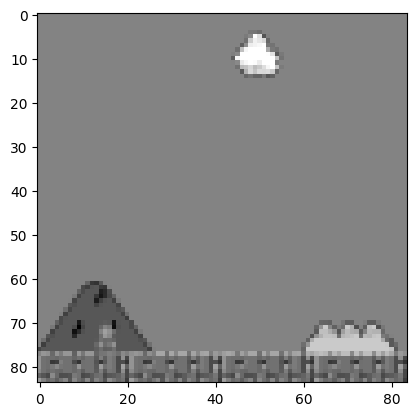

In [40]:
import matplotlib.pyplot as plt

plt.imshow(env.reset()[0][-1], cmap='gray')

We now have a preprocessed environment! We can proceed to working on our Agent.

## Training Convolutional PPO

I will be adapting a previous PPO implementation I made (https://github.com/arth-shukla/ppo-gym-cartpole) to use convolutions to process the observations.

I will use the same convolutions as in the original DeepMind papers, which I implemented for a DDQN (https://github.com/arth-shukla/ddqn-mario).

1. Conv2d with 32 8x8 kernels, stride 4 + nonlinearlity (we will use ReLU)
2. Conv2d with 64 4x4 kernels, stride 2 + nonlinearity
3. Conv2d with 64 3x3 kernels, stride 1 + nonlinearity
4. FC layer with 512 nodes + nonlinearity
5. FC layer with # nodes equal to # actions
6. Softmax &rarr; Categorical distr

The implementation can be found in `ppo-conv.py`.

In [41]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
from ppo.agent import PPOAgent
from tqdm import tqdm
import torch
from pathlib import Path

def train(
        logging=False, log_init=False, wandb_proj='Mario-PPO', checkpoint_dir = './checkpoints',
        pretrained_path=None,
        num_games=300, avg_over = 500, save_every = 100,
        buffer_size = 2048,
        batch_size = 64,
        epochs = 4,
        lr = 2.5e-4,
        scheduler_gamma = None,
        discount = .99,
        gae_lambda = 0.95,
        policy_clip = 0.2,
        norm_advantage = False,
        entropy_coeff = 0.01,
        critic_coeff = 0.5,
        max_grad_norm = 0.5,
        early_stop_kl = None,
        embed = 512,
    ):
    import wandb

    if logging and log_init:
        wandb.login()
        wandb.init(project=wandb_proj, config=dict(
            buffer_size = buffer_size,
            batch_size = batch_size,
            epochs = epochs,
            lr = lr,
            scheduler_gamma = scheduler_gamma,
            discount = discount,
            gae_lambda = gae_lambda,
            policy_clip = policy_clip,
            norm_advantage = norm_advantage,
            entropy_coeff = entropy_coeff,
            critic_coeff = critic_coeff,
            max_grad_norm = max_grad_norm,
            early_stop_kl = early_stop_kl,
            embed = embed,
        ))

    env = preprocessed_env()

    # create agent (note this is done in train because it needs hyperparams)
    agent = PPOAgent(
        obs_shape=env.observation_space.shape,
        act_shape=env.action_space.shape,
        act_n=env.action_space.n,
        buffer_size = buffer_size,
        batch_size = batch_size,
        epochs = epochs,
        lr = lr,
        scheduler_gamma = scheduler_gamma,
        discount = discount,
        gae_lambda = gae_lambda,
        policy_clip = policy_clip,
        norm_advantage = norm_advantage,
        entropy_coeff = entropy_coeff,
        critic_coeff = critic_coeff,
        max_grad_norm = max_grad_norm,
        early_stop_kl = early_stop_kl,
        embed = embed,
    )
    
    # load model if pretrained
    if pretrained_path != None:
        agent.load(path=pretrained_path)
    
    # data tracking
    score_hist = []
    avg_score = 0
    num_steps = 0

    # if using kldiv early end, track with this var
    early_end = False

    # num_games is the number of games to play, where each game ends
    # when the agent meets terminal conditions for the env
    for ep_num in tqdm(range(num_games)):

        obs = env.reset()[0].__array__()
        done = False
        score = 0
        steps = 0

        # run loop where model gathers data for "learn_every"
        # steps then learns using that information
        while not done:

            # choose action (actor)
            action, log_prob, val = agent.act(obs)

            # get results of action
            next_obs, reward, done, _, _ = env.step(action.item())

            # save data to memory for experience learning
            obs = torch.tensor(obs)
            reward = torch.tensor([reward])
            done = torch.tensor([done])
            agent.cache(obs, action, log_prob, val, reward, done)

            # when buffer full, learn and clear mem
            if agent.mem_full():
                next_obs_tensor = torch.from_numpy(next_obs.__array__()).to(agent.device)
                log_info = agent.learn(next_obs_tensor)
                agent.clear_mem()

                if logging:
                    log_info['num_steps'] = num_steps
                    wandb.log(log_info)
                
            # update obs and tracking vars
            obs = next_obs.__array__()
            score += reward
            steps += 1
            num_steps += 1

        score_hist.append(score)
        
        if (ep_num % save_every == 0) or (ep_num == 0):
            save_path = Path(checkpoint_dir) / Path(f'mario_ppo_{ep_num}.pt')
            agent.save(path=save_path)
    
        if logging:
            log_dict = {
                'train/total_rewards': score,
                'train/ep_len': steps,
                'ep_num': ep_num,
            }
            if len(score_hist) > avg_over:
                log_dict[f'train/avg_reward_last_{avg_over}'] = np.mean(score_hist[-avg_over:])
            wandb.log(log_dict)

    env.close()
    wandb.finish()

In [ ]:
import wandb
wandb.finish()

In [47]:
train(logging=True, log_init=True, wandb_proj='Mario-PPO', num_games=1000, avg_over=50)

  9%|▉         | 9/100 [17:39<2:58:32, 117.72s/it]


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (10,) + inhomogeneous part.

In [ ]:
# for lr in [5e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-4]:
#     train(logging=True, log_init=True, lr=lr, wandb_proj='Mario-PPO', num_games=100, avg_over=100)

## Let's Watch Our Bot Play!

In [ ]:
# def run_level(pretrained_path=None):
#     with torch.no_grad():
#         frames = []
        
#         env = preprocessed_env()

#         agent = DQNAgent(
#             state_space=env.observation_space.shape,
#             action_space=env.action_space.n,
#             max_memory_size=30000,
#             batch_size=32,
#             gamma=0.90,
#             lr=0.00025,
#             exploration_max=1.0,
#             exploration_min=0.02,
#             exploration_decay=0.99,
#             have_mem=False
#         )

#         if pretrained_path != None:
#             agent.load(pretrained_path)

#         agent.local_net.eval()

#         env.reset()

#         state, _ = env.reset()
#         state = torch.Tensor([state])
#         total_reward = 0
#         steps = 0

#         total_reward = 0
#         while True:
#             action = agent.act(state)
#             steps += 1

#             next_state, reward, terminal, truncated, info = env.step(int(action[0]))

#             total_reward += reward

#             state = torch.Tensor([next_state])
            
#             for x in env.render():
#                 frames.append(x.copy())

#             if terminal:
#                 break

#         env.close()
        
#         return frames

In [ ]:
# frames = run_level(pretrained_path='./acm_ai_ddqn_checkpoint.pt')

Let's watch our DDQN play Mario! Note that it might still lose sometimes...

In [ ]:
# display_vid(frames, fps=60)